# Improved balance data


In [1]:
import numpy as np
from dataset import H5Dataset
import matplotlib.pyplot as plt
from parula import parula_map

c:\Users\Kuanr\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data shape: (6300, 3, 300, 300) | target shape: (6300, 1, 300, 300)


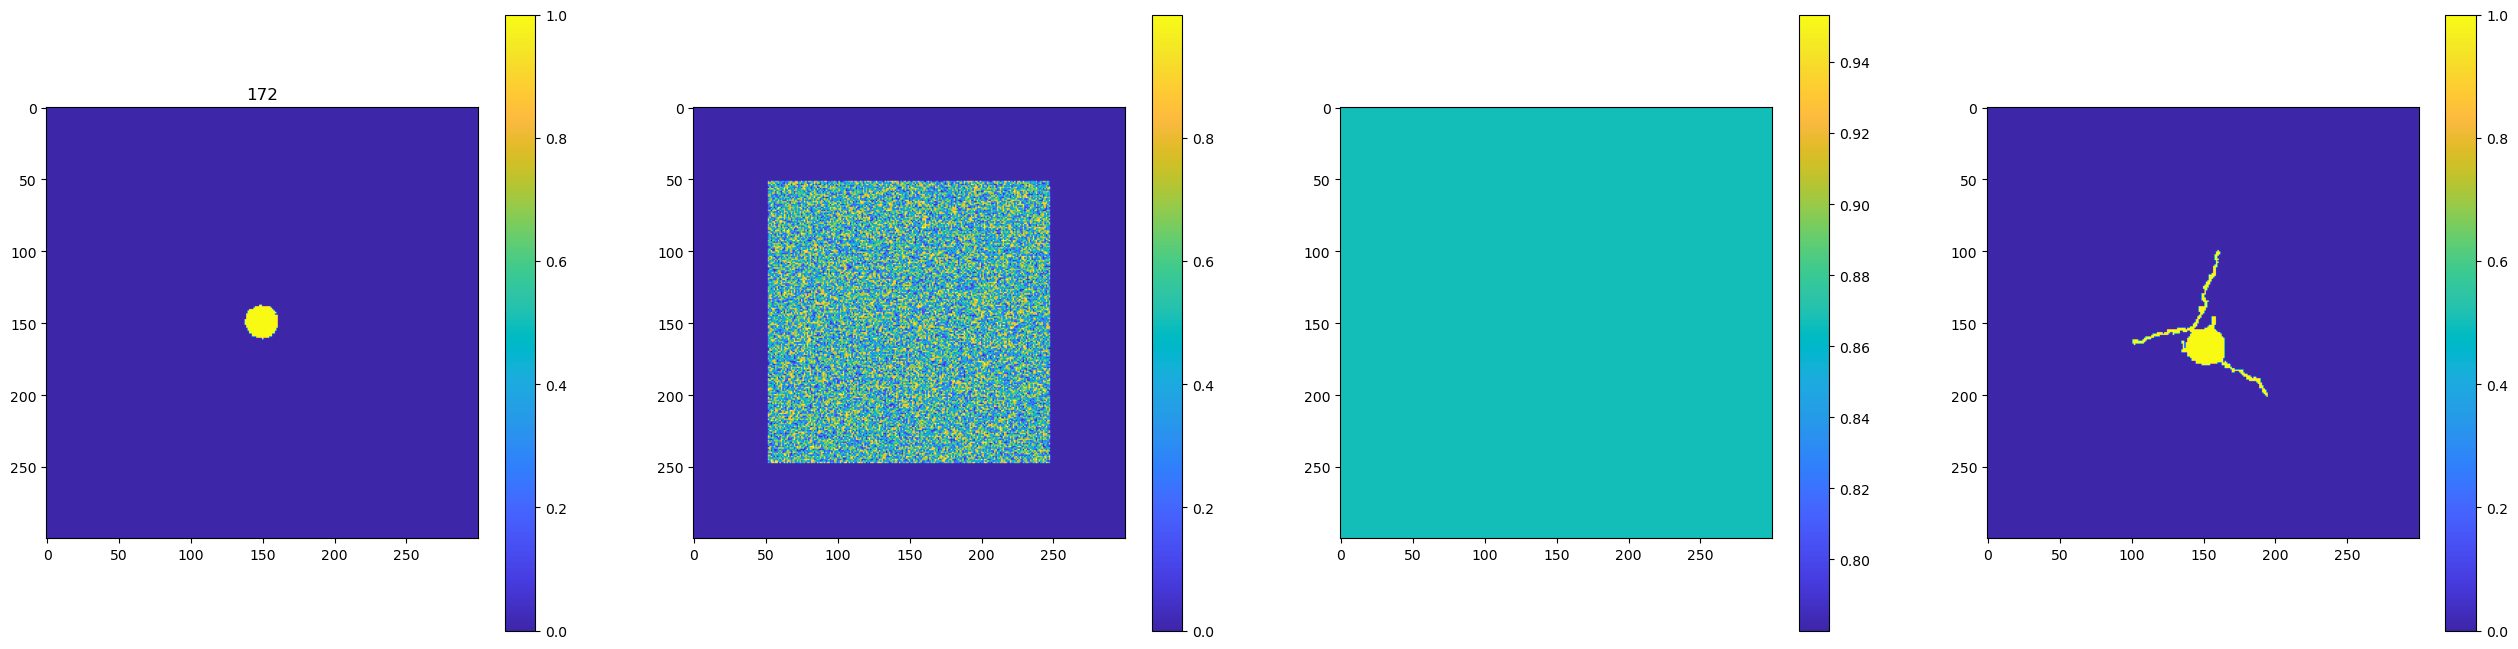

In [2]:
dataset = H5Dataset('../dataset_for_ML/NG_all_CNN_restructured_featureDrivenModel_04142023.hdf5')

x = dataset.data
y = dataset.target
print(f'data shape: {x.shape} | target shape: {y.shape}')

for i in range(1):
    id = np.random.randint(x.shape[0])
    plt.figure(figsize=(32, 8), dpi=100)
    plt.subplot(1,4,1)
    plt.imshow(x[id,0,...],cmap = parula_map)
    plt.title(id)
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.imshow(x[id,1,...],cmap = parula_map)
    plt.colorbar()
    plt.subplot(1,4,3)
    plt.imshow(x[id,2,...],cmap = parula_map)
    plt.colorbar()
    plt.subplot(1,4,4)
    plt.imshow(y[id,0,...],cmap = parula_map)
    plt.colorbar()
    # plt.savefig(f'./Figure/1.png')
    

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import data
from dataset import rdDataset_old
from dataset import H5Dataset
from model import rdcnn_2_larger
from math import log10

from tqdm import tqdm

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# cudnn.benchmark = True
path = './data'

# Parameters

params = {'test_split': .25,
          'shuffle_dataset': True,
          'batchsize': 48,
          'testBatchsize': 48,
          'random_seed': 42,
          'numworkers':0,
          'pinmemory':True}
    
max_epoches = 1000
learning_rate = 1e-4
drop_rate = 0.0

print('===> Loading datasets')
# Load All Dataset

# Creating data indices for training and validation splits:
training_data_loader, testing_data_loader = data.DatasetSplit(dataset, **params)

print('===> Building model')
# model = nn.DataParallel(rdcnn_2_larger(drop_rate)).to(device)
model = rdcnn_2_larger(drop_rate).to(device)

# criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

m = nn.Sigmoid()

def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(tqdm(training_data_loader), 1):
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)
        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    return epoch, epoch_loss / len(training_data_loader)
    
def test():
    avg_error = 0
    avg_loss = 0
    with torch.no_grad():
        for batch in tqdm(testing_data_loader):
            input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)

            # with torch.cuda.amp.autocast():
            prediction = model(input)
            tmp_error = 0
            for j in range(len(prediction)):
                tmp_error += torch.sqrt(torch.mean((m(prediction[j])-target[j])**2))/torch.max(target[j])
            avg_error += tmp_error / len(prediction)
            mse = criterion(prediction, target)
            avg_loss += mse
    print("===> Avg. Loss: {:.4f} ".format(avg_loss / len(testing_data_loader)))
    print("===> Avg. Error: {:.4f} ".format(avg_error / len(testing_data_loader)))
    return avg_loss / len(testing_data_loader),avg_error / len(testing_data_loader)

def checkpoint(epoch):
    model_out_path = "./checkpoints/model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))
    
model.eval()  

===> Loading datasets
===> Building model


rdcnn_2_larger(
  (encoder): Sequential(
    (0): Conv2d(3, 84, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Conv2d(84, 168, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.0, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(168, 336, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Dropout(p=0.0, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.0, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspos

In [4]:
L_train_loss = []
L_test_loss = []
L_test_error = []
for epoch in range(1, max_epoches + 1):
    train_loss = train(epoch)
    test_loss,test_error = test()
    checkpoint(epoch)
    L_train_loss.append(train_loss)
    L_test_loss.append(test_loss)
    L_test_error.append(test_error)
    print(f'###############################################################')

100%|██████████| 99/99 [01:57<00:00,  1.18s/it]


===> Epoch 1 Complete: Avg. Loss: 0.1433


100%|██████████| 33/33 [00:12<00:00,  2.59it/s]


===> Avg. Loss: 0.0584 
===> Avg. Error: 0.1227 
Checkpoint saved to ./checkpoints/model_epoch_1.pth
###############################################################


 25%|██▌       | 25/99 [00:28<01:25,  1.16s/it]

In [ ]:
# model = torch.load('./checkpoints/model_epoch_1000.pth')
# model.eval()

In [ ]:
import data
import importlib 
importlib.reload(data)
data.TestErrorPlot(model,device, testing_data_loader)

In [ ]:
from matplotlib import pyplot as plt
prediction_L = []
input_L = []
target_L = []
i=0

with torch.no_grad():
    for batch in testing_data_loader:
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)
        input_L.append(input)
        target_L.append(target)
        prediction = m(model(input))
        # prediction = model(input)
        prediction_L.append(prediction)
        i = i+1
        if i==10:
            break

In [ ]:
input_1 = dataset.data[id,:,:,:]
target_1 = dataset.target[id,0,:,:]
print(input_1.shape)
print(target_1.shape)
plt.figure(figsize=(18, 4), dpi=500)
plt.subplot(1,4,1)
plt.imshow(input_1[0,:,:],cmap=parula_map)
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(input_1[1,:,:],cmap=parula_map)
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(input_1[2,:,:],cmap=parula_map)
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(target_1,cmap=parula_map)
plt.colorbar()

In [ ]:
from data import ComputeTestError

numSteps = 20
numCases = int(dataset.data.shape[0]/numSteps)
cols = 5

ids = [0,4,9,14,19]
for j in range(numCases):
    plt.figure(figsize=(18, 7), dpi=800)
    
    for i in range(cols):
        
        # id = int(j*numSteps+i*(numSteps/(cols-1)))
        id = int(j*numSteps+ids[i])
        
        input_1 = dataset.data[id,:,:,:]
        target_1 = dataset.target[id,0,:,:]

        with torch.no_grad():
            prediction_1 = m(model(torch.tensor(np.expand_dims(input_1,axis=0)).to(device, torch.float)))
            prediction_1=prediction_1.cpu()
            err = ComputeTestError(prediction_1[0,0,:,:].cpu(),torch.tensor(target_1).cpu())

        plt.subplot(2,cols,i+1)
        plt.imshow(prediction_1[0,0,:,:].numpy(),cmap=parula_map)
        plt.title(f'Prediction at iter {int(input_1[2,0,0]*numSteps+1)}/{numSteps}')
        plt.colorbar()

        plt.subplot(2,cols,cols+i+1)
        abs_error = np.abs(target_1-prediction_1[0,0,:,:].numpy())
        plt.imshow(abs_error,cmap=parula_map)
        plt.title(f'Difference at iter {int(input_1[2,0,0]*numSteps+1)}/{numSteps}')
        plt.xlabel(f'MRE: {err*100:.2f}%')
        plt.clim(0,np.amax(abs_error))
        plt.colorbar()

    plt.savefig(f'./Figure/batchGen/results_bce_{j}.png')
    # plt.show()